In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from analyzePSFParameters import psfParameters
import analysisHelper as helper

## filter data

In [2]:
# load in dict of headers
with open('./ZorroHRHeaders_05ThruMid07.p','rb') as file:
    headers = pickle.load(file)
    
# load in dict of centroids
with open('../Fits/ZorroHRCentroids_05ThruMid07.p', 'rb') as file:
    centroidDict = pickle.load(file)

#load in fileNames
fileNames = []
for month in ['May', 'June', 'July']:  
    fnfile = f'./Zorro{month}HRStars.txt'
    fileNames += list(np.genfromtxt(fnfile, dtype='str', delimiter='\n'))

files_fullfwhm = helper.filterData(fileNames, './ZorroHRHeaders_05ThruMid07.p', 
                                   '../Fits/ZorroHRCentroids_05ThruMid07.p', fwhmWeight=1)
fullfwhm = psfParameters(source='Zorro', fileNumbers='Code/ZorroJulyHRStars.txt', baseDir='../', filters=(562,832))
fullfwhm.fileNumbers = files_fullfwhm
fullfwhm.loadAllParameters()
comR_full = np.array([np.sqrt((centroidDict[562][fn]['x']-128)**2+
                              (centroidDict[562][fn]['y']-128)**2) for fn in files_fullfwhm]).mean(axis=1)

files_halffwhm = helper.filterData(fileNames, './ZorroHRHeaders_05ThruMid07.p', 
                                   '../Fits/ZorroHRCentroids_05ThruMid07.p', fwhmWeight=0.5)
halffwhm = psfParameters(source='Zorro', fileNumbers='Code/ZorroJulyHRStars.txt', baseDir='../', filters=(562,832))
halffwhm.fileNumbers = files_halffwhm
halffwhm.loadAllParameters()
comR_half = np.array([np.sqrt((centroidDict[562][fn]['x']-128)**2+
                              (centroidDict[562][fn]['y']-128)**2) for fn in files_halffwhm]).mean(axis=1)

## selection plot

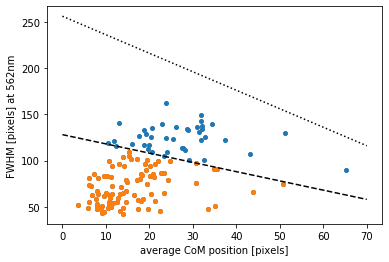

In [153]:
plt.plot(comR_half, halffwhm.parameters['15'][562]['size'][:,-1]/halffwhm.scale[halffwhm.filters[0]],'o', ms=4)
plt.plot(comR_full, fullfwhm.parameters['15'][562]['size'][:,-1]/fullfwhm.scale[fullfwhm.filters[0]],'o', ms=4)

plt.plot(np.linspace(0,70,10), 128*np.ones(10) - np.linspace(0,70,10), 'k--')
plt.plot(np.linspace(0,70,10), 2*(128*np.ones(10) - np.linspace(0,70,10)), 'k:')

plt.ylabel('FWHM [pixels] at 562nm')
plt.xlabel('average CoM position [pixels]');

## date/time of observations

In [59]:
def dateTimeDict(headers, fileNumbers):
    tmp = [(headers[k]['DATE-OBS'].split('-')[1:] + headers[k]['OBSTIME'].split(':')[:2], k) 
       for k in headers.keys() if k in fileNumbers]

    d = {}
    for obs in tmp:
        if int(obs[0][2]) < 15:
            day = obs[0][0] + obs[0][1]
            time = int(obs[0][2])*60 + int(obs[0][3])
        else:
            day = obs[0][0] + str(int(obs[0][1])+1)
            time = int(obs[0][2])*60 + int(obs[0][3]) - 1440
        if day in d.keys():
            d[day].append((obs[1], time))
        else:
            d[day] = [(obs[1], time)]
    return d

d_full = dateTimeDict(headers, fullfwhm.fileNumbers)
d_half = dateTimeDict(headers, halffwhm.fileNumbers)

In [150]:
def plotDateTime(axes0, axes1, axes2, axes3, nights, d, pclass, kwargs={}):
    for i in range(len(nights)):
        key = nights[i]
        try:
            # file numbers for the sets in night i
            fNs = [d[key][i][0] for i in range(len(d[key]))]
        except KeyError:
            continue
        # times for the sets in night i, in minutes
        times = [d[key][i][1] for i in range(len(d[key]))]

        # find the indices of the datasets in night i
        datasets = [np.where(f == np.array(pclass.fileNumbers))[0][0] for f in fNs]
        sizes = pclass.parameters['15'][562]['size'][datasets,-1]
        g1 = pclass.parameters['15'][562]['g1'][datasets,-1]
        g2 = pclass.parameters['15'][562]['g2'][datasets,-1]
        
        x = np.array([centroidDict[562][f]['x'] for f in np.array(pclass.fileNumbers)[datasets]])
        y = np.array([centroidDict[562][f]['y'] for f in np.array(pclass.fileNumbers)[datasets]])
        centroidVar = np.sqrt(np.mean((x-x.mean(axis=1)[:,None])**2, axis=1) + 
                              np.mean((y-y.mean(axis=1)[:,None])**2, axis=1))

        axes0[i].plot(times, sizes, 'k.', **kwargs)
        axes1[i].plot(times, g1, 'k.', **kwargs)
        axes2[i].plot(times, g2, 'k.', **kwargs)
        axes3[i].plot(times, centroidVar, 'k.', **kwargs)

        axes0[i].set_title(key[:2]+'/'+key[2:])
        
        axes0[i].set_xticks([0, 180, 360, 540])
        axes0[i].set_xticklabels([])
        axes1[i].set_xticks([0, 180, 360, 540])
        axes1[i].set_xticklabels([])
        axes2[i].set_xticks([0, 180, 360, 540])
        axes2[i].set_xticklabels([])
        axes3[i].set_xticks([0, 180, 360, 540])
        axes3[i].set_xticklabels([0, 3, 6, 9])
        
        axes0[i].set_xlim([-100,700])    
        axes1[i].set_xlim([-100,700])    
        axes2[i].set_xlim([-100,700]) 
        axes3[i].set_xlim([-100,700]) 

    axes0[0].set_ylabel('size [arcsec]', fontsize=12);
    axes1[0].set_ylabel('g1', fontsize=12);
    axes2[0].set_ylabel('g2', fontsize=12);
    axes3[0].set_ylabel('centroid $\sigma$', fontsize=12);

    return axes0, axes1, axes2, axes3

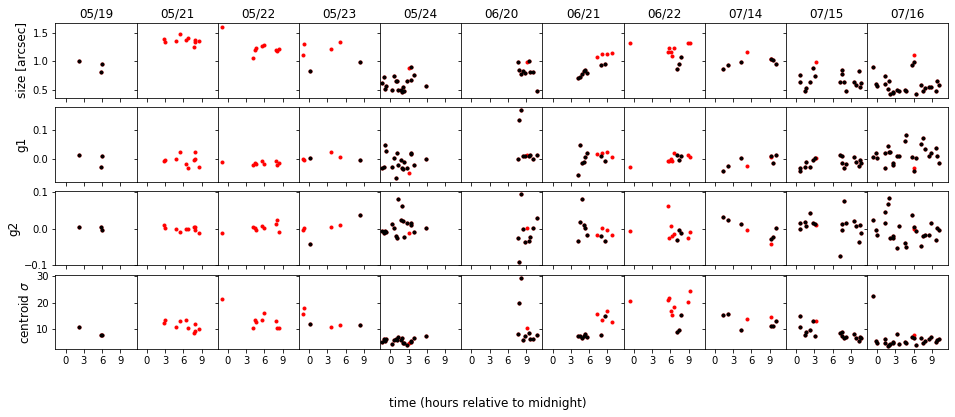

In [151]:
% matplotlib inline

nights = np.sort([k for k in d_half.keys()])
f, (axes0, axes1, axes2, axes3) = plt.subplots(4, len(nights), sharey='row', figsize=(16,6), 
                                                gridspec_kw={'wspace':0, 'hspace':0.125})

axes0, axes1, axes2, axes3 = plotDateTime(axes0, axes1, axes2, axes3, nights, d_half, halffwhm, 
                                          kwargs={'marker':'.', 'color':'r'})
axes0, axes1, axes2, axes3 = plotDateTime(axes0, axes1, axes2, axes3, nights, d_full, fullfwhm)
    
f.text(0.5, 0.00, 'time (hours relative to midnight)', fontsize=12, ha='center', va='center');
plt.show()